In [1]:
%load_ext autoreload
%autoreload 2
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import torch.distributions as dist
import pickle
from tqdm import tqdm
import numpy as np
from models import RegressionMCDropoutModel

In [2]:
with open('dataset.pickle', 'rb') as f:
    data = pickle.loads(f.read())
mapping = data['mapping']

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = np.array(X).astype(np.float32)
        self.y = np.array(y).astype(np.float32)
        assert self.X.shape[0]==self.y.shape[0]

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]


X_train, X_test, y_train, y_test, train_labels, test_labels = train_test_split(data['X'], data['y_regression'], data['y'], test_size=0.20)

In [4]:
train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

net = RegressionMCDropoutModel(X_train[0].shape[0], train_data_size=X_train.shape[0], lengthscale=1).cuda()
net.load_state_dict(torch.load('bayesian_regression_model'))

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

losses = []
val_losses = []

In [6]:
t = tqdm(range(300))

for epoch in t:  # loop over the dataset multiple times
    total_loss = 0
    net.train(True)
    for i, data in enumerate(train_loader, 0):
        inputs, targets = data
        inputs = inputs.cuda()
        targets = targets.cuda()
        optimizer.zero_grad()
        pred = net(inputs)
        loss = net.getLoss(pred, targets).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.cpu().item()

    train_loss = total_loss/(i+1)
    losses.append(train_loss)

    total_loss = 0
    pred = []
    net.train(False)
    for i, data in enumerate(test_loader, 0):
        inputs, targets = data
        inputs = inputs.cuda()
        targets = targets.cuda()
        pred = net(inputs)
        loss = net.getLoss(pred, targets).mean()
        total_loss += loss.cpu().item()


    val_loss = total_loss/(i+1)
    val_losses.append(val_loss)
    t.set_description(f'loss : {train_loss:.6f}, val_loss: {val_loss:.6f}')

print('Finished Training')

loss : 0.157303, val_loss: 0.167364: 100%|██████████| 300/300 [14:45<00:00,  2.95s/it]Finished Training



In [7]:
torch.save(net.state_dict(), 'bayesian_regression_model')

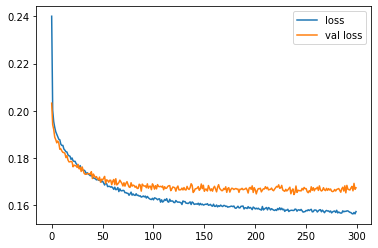

In [8]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
# smooth_loss = savgol_filter(losses, 51, 3)

plt.plot(losses, label='loss')
plt.plot(val_losses, label='val loss')
# plt.plot(smooth_loss, label='smooth loss')
plt.legend()
plt.show();

In [9]:
# plt.plot(f1_scores, label='f1')
# smooth_f1 = savgol_filter(f1_scores, 101, 3)
# plt.plot(smooth_f1, label='smooth f1')
# plt.legend()
# plt.show();

In [10]:
net.train(False)
points = []
sigmas = []
targets = []
for i, data in enumerate(test_loader, 0):
    inputs, target = data
    inputs = inputs.cuda()
    loc, sigma = net.predict(inputs, num_samples=200)
    points.append(loc.detach().cpu().numpy())
    sigmas.append(sigma.detach().cpu().numpy())
    targets.append(target.detach().cpu().numpy())

points = np.concatenate(points)
sigmas = np.concatenate(sigmas)
targets = np.concatenate(targets)
labels = test_labels

In [11]:
sig_prod = np.sqrt(sigmas[:, 0]*sigmas[:, 1])

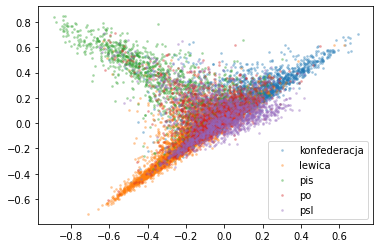

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(5):
    selected = labels==i
    ax.scatter(points[selected][:,0], points[selected][:,1], label=mapping[i], alpha=0.3, s=3)

plt.legend()
plt.show();

In [13]:
def rmse(y, y_hat):
    """Compute root mean squared error"""
    return np.sqrt(np.mean((y - y_hat)**2))

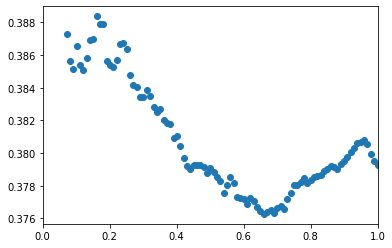

In [14]:
x = []
y = []

sorted_sigmas = np.sort(sig_prod)

for percent in range(1000, sorted_sigmas.shape[0], sorted_sigmas.shape[0]//100):
    treshold = sorted_sigmas[percent]
    selected = sig_prod<=treshold
    x_ = selected.sum()/labels.shape[0]
    y_ = rmse(points[selected], targets[selected])
    x.append(x_)
    y.append(y_)
plt.scatter(x, y)
plt.xlim(0, 1);

In [15]:
net.train(False)
points = []
targets = []
for i, data in enumerate(test_loader, 0):
    inputs, target = data
    inputs = inputs.cuda()
    loc = net(inputs, deterministic=True)
    # loc = net.predict(inputs, num_samples=100)[0]
    points.append(loc.detach().cpu().numpy())
    targets.append(target.detach().cpu().numpy())

points = np.concatenate(points)
targets = np.concatenate(targets)
labels = test_labels

deterministic_rmse = rmse(points, targets)
print(f'RMSE with deterministic model: {rmse(points, targets)}')

RMSE with deterministic model: 0.3801352381706238


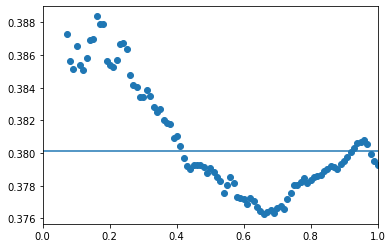

In [16]:
plt.scatter(x, y)
plt.plot([0, 1], [deterministic_rmse,deterministic_rmse])
plt.xlim(0, 1);

In [17]:
for i, data in enumerate(test_loader, 0):
    inputs, target = data
    inputs = inputs.cuda()
    samples = torch.stack([net.forward(inputs) for _ in range(10)], dim=0)
    break